# What is a Tensor?
What's a tensor?
- a $n$ dimensional array
- 0 dimensional tensor: scalar (number)
- 1 dimensional tensor: vector
- 2 dimensional tensor: matrix

## Data Flow Graphs

In [1]:
import tensorflow as tf
a = tf.add(3, 5)

## Visualizing the Data Flow Graph

And while for small examples you might be able to look at the code and immediately see what is going on, larger computation graphs might not be so obvious. Visualizing the graph can help both in diagnosing issues with the computation itself, but also in understanding how certain operations in TensorFlow work and how are things put together.

All we need to do is save it using the `tf.summary.FileWriter`, which takes a directory and a graph, and serializes the graph in a format that TensorBoard can read. The directory can be anything you'd like, just make sure you point to the same directory using the tensorboard --logdir=DIR command (DIR being the directory you specified to the FileWriter).

In [2]:
tf.summary.FileWriter("logs", tf.get_default_graph()).close()

Next, open up a console and navigate to the same directory from which you executed the FileWriter command, and run 

```sh
tensorboard --logdir=logs

```
This will launch an instance of TensorBoard which you can access at http://localhost:6006. Then navigate to the Graphs section and you should see a graph that looks like the following image. Note that you can also click on the nodes in the graph to inspect them further.

You should get something like this:
![alt text](images/adder_graph.png "Title")



Let's see what the value of `a` is:

In [5]:
print(a)

Tensor("Add:0", shape=(), dtype=int32)


## How to get the value of `a`?

Create a `session`, assign it to a variable `sess` so that we can access it later. Within the session, evaluate the graph to fetch the value of `a`

In [4]:
sess = tf.Session()
print(sess.run(a))
sess.close()

8


Alternatively, we can do the following:

In [5]:
with tf.Session() as sess:
    print(sess.run(a))

8


`tf.Session()`: a session object encapsulates the environment in which operation objects are executed and Tensor objects are evaluated

## Practice With More Graphs

In [6]:
x = 2
y = 3
op1 = tf.add(x, y)
op2 = tf.multiply(x, y)
op3 = tf.pow(op1, op2)
with tf.Session() as sess:
    op3 = sess.run(op3)

Here is how the graph looks like, see if you can generate it yourself.
![alt text](images/graph2.png "Title")

## TensorFlow Variables

A TensorFlow variable is the best way to represent shared, persistent state manipulated by your program.

When you train a model, you use variables to hold and update parameters. Variables are in-memory buffers containing tensors.

In [7]:
W1 = tf.ones((2,2))
W2 = tf.Variable(tf.zeros((2,2)), name="weights")

with tf.Session() as sess:
    print(sess.run(W1))
    sess.run(tf.global_variables_initializer())
    print(sess.run(W2))

[[ 1.  1.]
 [ 1.  1.]]
[[ 0.  0.]
 [ 0.  0.]]


TensorFlow variables must be initialized before they have variables! Do so with `tf.global_variables_initializer()`. Note that older tutorials might use `tf.initialize_all_variables()`, that has been deprecated.

### Updating Variable State

To assign a value to a variable, use method `assign`. 


In [8]:
state = tf.Variable(0, name="counter")
new_value = tf.add(state, tf.constant(1))
update = tf.assign(state, new_value)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(state))
    for _ in range(3):
        sess.run(update)
        print(sess.run(state))

0
1
2
3


### Fetching Variable State

Calling `sess.run(var)` on a `tf.Session()` object retrieves its value. Can retrieve multiple variables simultaneouly with `sess.run([var1, var2])`

(See Fetches in TF docs)
(insert the graph)

In [9]:
input1 = tf.constant(3.0)
input2 = tf.constant(2.0)
input3 = tf.constant(5.0)
intermed = tf.add(input2, input3)
mul = tf.multiply(input1, intermed)

with tf.Session() as sess:
    result = sess.run([mul, intermed])
    print(result)

[21.0, 7.0]


### Inputing Data

As far, all previous examples have manually defined tensors. What if we want to input external data into TensorFlow?

We can use `tf.placeholder` variables (dummy nodes that provide entry points for data to computational graph). A `feed_dict` is a python dictionary that maps `tf.placeholder` vars to data.

In [10]:
input1 = tf.placeholder(tf.float32)
input2 = tf.placeholder(tf.float32)

output = tf.multiply(input1, input2)

with tf.Session() as sess:
    print(sess.run([output], feed_dict={input1:[7.], input2:[2.]}))

[array([ 14.], dtype=float32)]


## Example: Linear Regression

Make sure that you have `seaborn` and `matplotlib` installed. To display the `matplotlib` plots inline, add:

```
%matplotlib inline
```

in the code cell

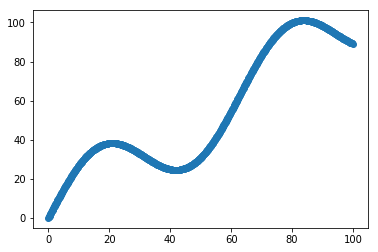

In [1]:
import tensorflow as tf
import numpy as np
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

# Define input data
X_data = np.arange(100, step=.1)
y_data = X_data + 20 * np.sin(X_data/10)

# Plot input data
plt.scatter(X_data, y_data)

In [2]:
# Define data size and batch size
n_samples = 1000
batch_size = 100

# TensorFlow is particular about shapes, so resize
X_data = np.reshape(X_data, (n_samples, 1))
y_data = np.reshape(y_data, (n_samples, 1))

# Define placeholders for input
X = tf.placeholder(tf.float32, shape=(batch_size, 1))
y = tf.placeholder(tf.float32, shape=(batch_size, 1))

In [3]:
# Define variables to be learned
with tf.variable_scope("linear-regression"):
    W = tf.get_variable("weights", (1,1),
                        initializer = tf.random_normal_initializer())
    b = tf.get_variable("bias", (1,),
                        initializer = tf.constant_initializer(0.0))
    y_pred = tf.matmul(X, W) + b
    loss = tf.reduce_sum((y - y_pred)**2/n_samples)


Loss function is defined as:
$$J(W,b) = \frac{1}{N}\sum_{i=1}^{N}(y_i-(W_{x_i}+b))^2$$
Also known as mean square error.

[array([[ 1.03743494]], dtype=float32), array([ 0.27547979], dtype=float32)]


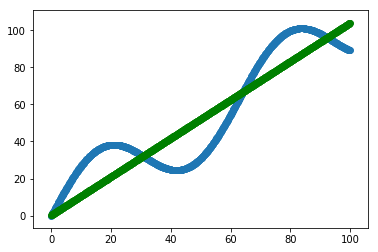

In [4]:
# Define optimizer operation
opt_operation = tf.train.AdamOptimizer().minimize(loss)

with tf.Session() as sess:
    # Initialize all variables in graph
    sess.run(tf.global_variables_initializer())
    # Gradient descent for 500 steps:
    for _ in range(500):
        # Select from random mini batch
        indices = np.random.choice(n_samples, batch_size)
        X_batch, y_batch = X_data[indices], y_data[indices]
        # Do gradient descent step
        _, loss_val = sess.run([opt_operation, loss], feed_dict={X: X_batch, y: y_batch})
    print(sess.run([W, b]))

    # Display results
    plt.scatter(X_data, y_data)
    plt.scatter(X_data, sess.run(W) * X_data + sess.run(b), c='g')


(todo add more analysis and graph)

#### TensorFlow Computation

Tensflow nodes in computation graph have attached gradient operations. Use backpropagation to compute required gradients for all variables in the graph.

### Bonus

How does the computational graph look like in TensorBoard?